In [30]:
import pandas as pd
import numpy as np
import warnings
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [2]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/47/78/27daa8e0287ce205908f089564472af42eb4646146a51d2fbb76ef8f3880/xgboost-3.0.1-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/150.0 MB 1.1 MB/s eta 0:02:23
   ---------------------------------------- 0.1/150.0 MB 1.1 MB/s eta 0:02:23
   ---------------------------------------- 0.2/150.0 MB 1.4 MB/s eta 0:01:49
   ---------------------------------------- 0.2/150.0 MB 1.2 MB/s eta 0:02:10
   ---------------------------------------- 0.4/150.0 MB 1.5 MB/s eta 0:01:41
   ---------------------------------------- 0.4/150.0 MB 1.5 MB/s eta 0:01:38
   ---------------------------------------- 0.5/150.0 MB 1.5 MB/s eta 0:01:42
   ---------------------------------------- 0.6/150.0 MB 1.7 MB/s eta 0:01:30
   --------------------------

In [4]:
warnings.filterwarnings('ignore', category=RuntimeWarning, module='numpy')



In [5]:
df = pd.read_csv("encoded_hr_data.csv")
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())


Dataset Shape: (1434, 50)
Columns: ['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_Flag', 'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely', 'Department_Research & Development', 'Department_Sales', 'EducationField_Life Sciences', 'EducationField_Marketing', 'EducationField_Medical', 'EducationField_Other', 'EducationField_Technical Degree', 'Gender_Male', 'JobRole_Human Resources', 'JobRole_Laboratory Technician', 'JobRole_Manager', 'JobRole_Manufacturing Director', 'JobRole_Research Director', '

In [6]:
print("\nChecking for NaN values:\n", df.isna().sum())
print("Checking for infinite values:\n", df.select_dtypes(include=[np.number]).apply(lambda x: np.isinf(x).sum()))


Checking for NaN values:
 Age                                  0
Attrition                            0
DailyRate                            0
DistanceFromHome                     0
Education                            0
EmployeeCount                        0
EmployeeNumber                       0
EnvironmentSatisfaction              0
HourlyRate                           0
JobInvolvement                       0
JobLevel                             0
JobSatisfaction                      0
MonthlyIncome                        0
MonthlyRate                          0
NumCompaniesWorked                   0
Over18                               0
PercentSalaryHike                    0
PerformanceRating                    0
RelationshipSatisfaction             0
StandardHours                        0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
WorkLifeBalance                      0
YearsAtCompany                       

In [7]:
df.drop(columns=["Attrition"], inplace=True, errors='ignore')

In [8]:
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Handle mixed types
    label_encoders[col] = le


In [9]:
print("\nData types after encoding:\n", df.dtypes)


Data types after encoding:
 Age                                  int64
DailyRate                            int64
DistanceFromHome                     int64
Education                            int64
EmployeeCount                        int64
EmployeeNumber                       int64
EnvironmentSatisfaction              int64
HourlyRate                           int64
JobInvolvement                       int64
JobLevel                             int64
JobSatisfaction                      int64
MonthlyIncome                        int64
MonthlyRate                          int64
NumCompaniesWorked                   int64
Over18                               int32
PercentSalaryHike                    int64
PerformanceRating                    int64
RelationshipSatisfaction             int64
StandardHours                        int64
StockOptionLevel                     int64
TotalWorkingYears                    int64
TrainingTimesLastYear                int64
WorkLifeBalance          

In [10]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Attrition_Flag')
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

In [12]:
X = df.drop("Attrition_Flag", axis=1)
y = df["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in y_train:", y_train.value_counts().to_dict())



Training set shape: (1147, 48)
Test set shape: (287, 48)
Class distribution in y_train: {0: 961, 1: 186}


In [14]:
scaler = StandardScaler()
if np.any(np.isnan(X_train)) or np.any(np.isinf(X_train)):
    raise ValueError("X_train contains NaN or infinite values before scaling")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)  # Ratio of negative to positive samples
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Scale Pos Weight: 5.17


In [17]:
xgb = XGBClassifier(
    n_estimators=200,        # Number of trees
    max_depth=6,             # Maximum depth of trees
    learning_rate=0.1,       # Step size for updates
    scale_pos_weight=scale_pos_weight,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss'    # Metric for training
)


In [18]:
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
cv_scores = cross_val_score(xgb, X_train_scaled, y_train, cv=3, scoring='f1_macro')
print("\nCross-Validation F1 Macro Scores (XGBoost):", cv_scores)
print("Mean CV F1 Macro Score:", cv_scores.mean(), "±", cv_scores.std())



Cross-Validation F1 Macro Scores (XGBoost): [0.69463147 0.69450862 0.72067933]
Mean CV F1 Macro Score: 0.7032731393025492 ± 0.012308138862116971


In [21]:
y_pred_proba = xgb.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores, 0)  # Handle NaN in F1-scores
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal threshold (XGBoost): {optimal_threshold:.2f}")


Optimal threshold (XGBoost): 0.13


In [22]:
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

In [23]:
print("\nTest Set Classification Report (XGBoost with adjusted threshold):")
print(classification_report(y_test, y_pred))



Test Set Classification Report (XGBoost with adjusted threshold):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       240
           1       0.41      0.60      0.49        47

    accuracy                           0.79       287
   macro avg       0.66      0.71      0.68       287
weighted avg       0.83      0.79      0.81       287



In [24]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (XGBoost):")
print(feature_importance)



Feature Importance (XGBoost):
                              Feature  Importance
47                       OverTime_Yes    0.107821
19                   StockOptionLevel    0.066690
9                            JobLevel    0.057957
20                  TotalWorkingYears    0.053903
30                   Department_Sales    0.047690
10                    JobSatisfaction    0.043976
46               MaritalStatus_Single    0.038238
6             EnvironmentSatisfaction    0.034624
24                 YearsInCurrentRole    0.033962
8                      JobInvolvement    0.031594
23                     YearsAtCompany    0.031279
25            YearsSinceLastPromotion    0.026312
33             EducationField_Medical    0.026054
0                                 Age    0.025675
1                           DailyRate    0.025441
11                      MonthlyIncome    0.025334
21              TrainingTimesLastYear    0.025150
17           RelationshipSatisfaction    0.024886
15                 


SHAP Summary Plot:


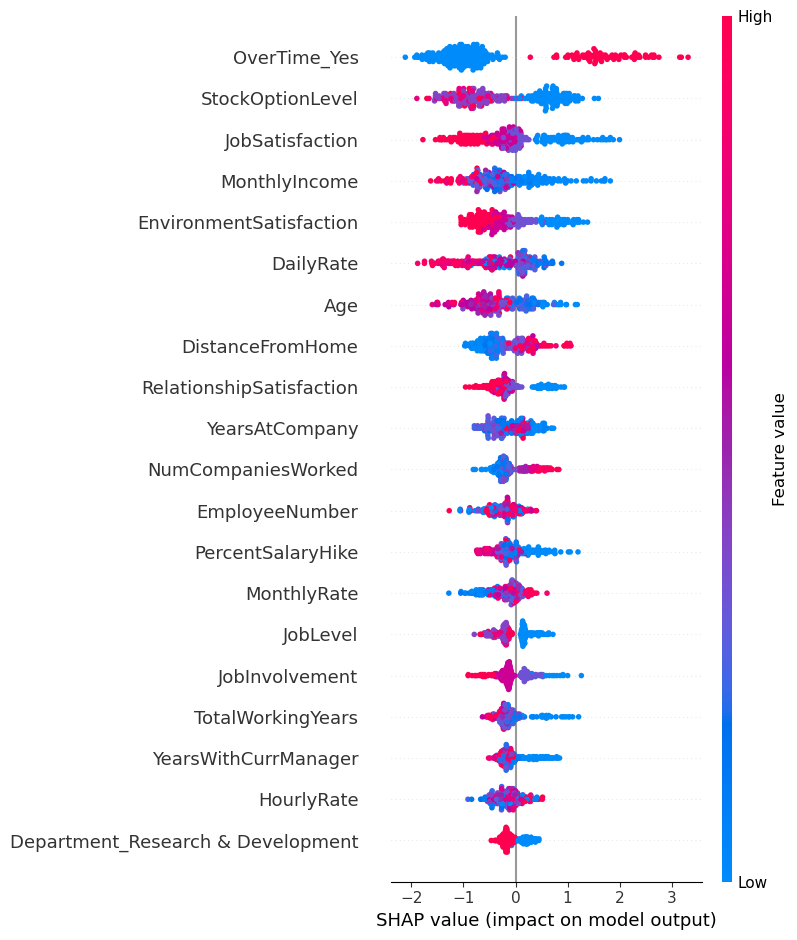

In [32]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)
print("\nSHAP Summary Plot:")
shap.summary_plot(shap_values, X_test_df, plot_type="dot", show=False)



SHAP Bar Plot:


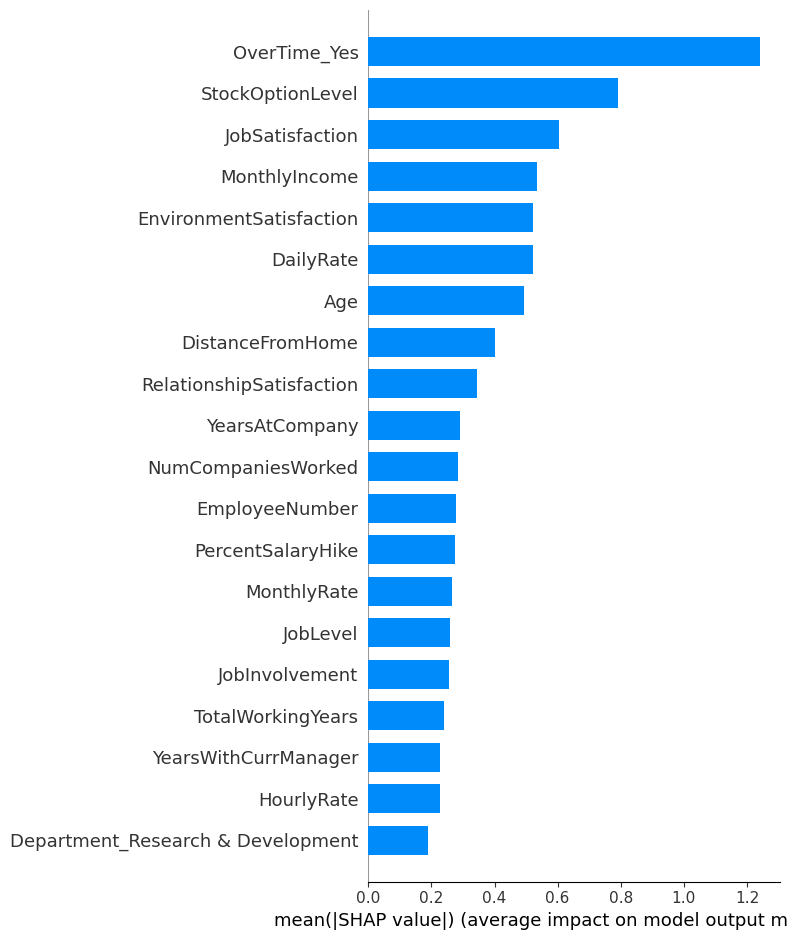

In [34]:
print("\nSHAP Bar Plot:")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)


In [35]:
tp_indices = np.where((y_pred == 1) & (y_test == 1))[0]  # True Positives
fp_indices = np.where((y_pred == 1) & (y_test == 0))[0]

In [36]:
tp_idx = tp_indices[0] if len(tp_indices) > 0 else None
fp_idx = fp_indices[0] if len(fp_indices) > 0 else None

In [39]:
if tp_idx is not None:
    print(f"\nSHAP Force Plot for a True Positive (Index {tp_idx}):")
    shap.initjs()  # For Jupyter visualization (if running in a notebook)
    shap.force_plot(explainer.expected_value, shap_values[tp_idx], X_test_df.iloc[tp_idx], show=False, matplotlib=True)
   


SHAP Force Plot for a True Positive (Index 3):


In [40]:
if fp_idx is not None:
    print(f"\nSHAP Force Plot for a False Positive (Index {fp_idx}):")
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[fp_idx], X_test_df.iloc[fp_idx], show=False, matplotlib=True)
    plt.savefig(f"shap_force_plot_fp_{fp_idx}.png")
    plt.close()


SHAP Force Plot for a False Positive (Index 12):
